<a href="https://colab.research.google.com/github/donghyuun/ProjectAW/blob/main/shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inlet Pressure(유입압력) 예측에 대한 인자별 영향력 검사

In [3]:
import pandas as pd
import numpy as np
import shap

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

shap.initjs()
mpl.rcParams['axes.unicode_minus'] = False

렌덤포레스트 모델 학습

In [6]:
df = pd.read_csv('raw_data_1007_1015.csv')  # 업로드한 파일명으로 변경

# X, Y 설정
Y = df['Inlet Pressure']  # Inlet Pressure 예측
X = df[['Treated Water Conductivity', 'pH',
        'Inlet + Concentrate Water Conductivity',
        'Treated Water Conductivity',
        'Concentrate Water Conductivity',
        'Inlet Flow Rate',
        'Concentrate Flow Rate',
        'Treated Water Flow Rate',
        'Discharge Flow Rate',
        'Concentrate Pressure']]  # 나머지 인자들

# 학습, 테스트 데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=0)

# Random Forest Regressor 모델 학습
rf = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=20)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0)

설명 모델 및 Shapely value 데이터 프레임 생성

In [9]:
# 설명 모델 생성
explainer = shap.TreeExplainer(rf)
# 트레인 셋에서의 shap value
shap_values_train = explainer.shap_values(X_train)
# 테스트 셋에서의 shap value
shap_values_test = explainer.shap_values(X_test)
# SHAP value 데이터프레임 생성
feature_names = ['Treated Water Conductivity', 'pH',
                 'Inlet + Concentrate Water Conductivity',
                 'Treated Water Conductivity',
                 'Concentrate Water Conductivity',
                 'Inlet Flow Rate',
                 'Concentrate Flow Rate',
                 'Treated Water Flow Rate',
                 'Discharge Flow Rate',
                 'Concentrate Pressure']

# SHAP value 데이터프레임 생성 (컬럼명 포함)
df_shap_values_train = pd.DataFrame(shap_values_train, columns=feature_names)
df_shap_values_test = pd.DataFrame(shap_values_test, columns=feature_names)

X_train.head()
X_test.head()
df_shap_values_train.head()
df_shap_values_test.head()

,Treated Water Conductivity,pH,Inlet + Concentrate Water Conductivity,Treated Water Conductivity,Concentrate Water Conductivity,Inlet Flow Rate,Concentrate Flow Rate,Treated Water Flow Rate,Discharge Flow Rate,Concentrate Pressure
0,3.869522e-07,1.747691e-06,0.000032,0.000074,2.709439e-04,0.005281,0.000146,0.000440,-7.689520e-07,2.732742
1,3.869522e-07,1.314830e-06,0.006093,-0.004372,-1.427215e-04,0.082631,0.000049,0.009189,-1.266524e-06,-1.705486
2,2.312969e-07,2.917016e-07,0.000032,0.000075,-4.973612e-05,0.005281,0.000146,0.000440,-7.689520e-07,1.856986
3,6.230587e-07,1.747691e-06,0.000032,0.000075,-7.715785e-07,0.005281,0.000146,0.000440,-7.689520e-07,2.162327
4,3.869522e-07,1.747691e-06,0.000155,0.000074,2.709439e-04,0.005281,0.000146,0.000440,-7.689520e-07,2.805003


기본값(트레인 데이터셋 모델 출력의 평균) 출력

In [13]:
# 트레이닝 데이터의 기본값
print('트레이닝 데이터: ','\n', shap_values_train.base[0])
print('기본값: ', shap_values_train.base[0][10], '\n')

# 테스트 데이터의 기본값
print('테스트 데이터: ','\n', shap_values_test.base[0])
print('기본값: ', shap_values_test.base[0][10])

# 기본값은 트레이닝 데이터에서 계산되므로 테스트 데이터에서도 동일함
base_value = shap_values_train.base[0][10][0]

트레이닝 데이터:  
 [[ 2.31296872e-07]
 [ 1.31482958e-06]
 [ 3.22562365e-05]
 [ 7.46172952e-05]
 [-4.97361206e-05]
 [ 5.28122448e-03]
 [-3.81224466e-06]
 [ 4.40136888e-04]
 [-7.68952000e-07]
 [ 9.45579119e-01]
 [ 8.47886857e+00]]
기본값:  [8.47886857] 

테스트 데이터:  
 [[ 3.86952233e-07]
 [ 1.74769140e-06]
 [ 3.22562365e-05]
 [ 7.41713163e-05]
 [ 2.70943855e-04]
 [ 5.28102860e-03]
 [ 1.46300299e-04]
 [ 4.40136888e-04]
 [-7.68952000e-07]
 [ 2.73274185e+00]
 [ 8.47886857e+00]]
기본값:  [8.47886857]


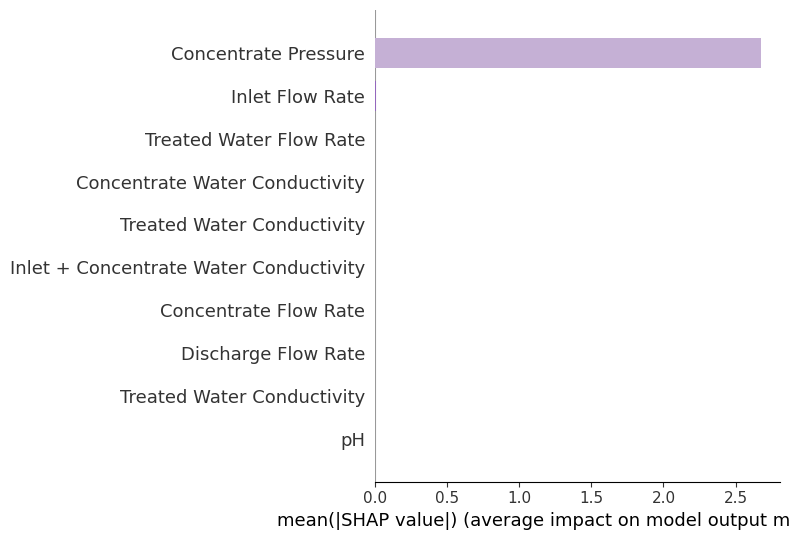

In [10]:
# 컬럼 개수에 맞춰 색상 자동 생성
num_features = X_train.shape[1]
colors = plt.cm.tab20.colors[:num_features]  # 적절한 색상 팔레트에서 컬럼 개수만큼 추출

# 피처별 평균 임팩트 확인 - 각 피처에 해당하는 SHAP 값의 집계
shap.summary_plot(
    shap_values_train,  # SHAP 값 (훈련 데이터)
    X_train,            # 원본 데이터 (훈련 데이터)
    plot_type='bar',    # 막대형 플롯
    color=colors        # 컬럼 개수에 맞는 색상 적용
)

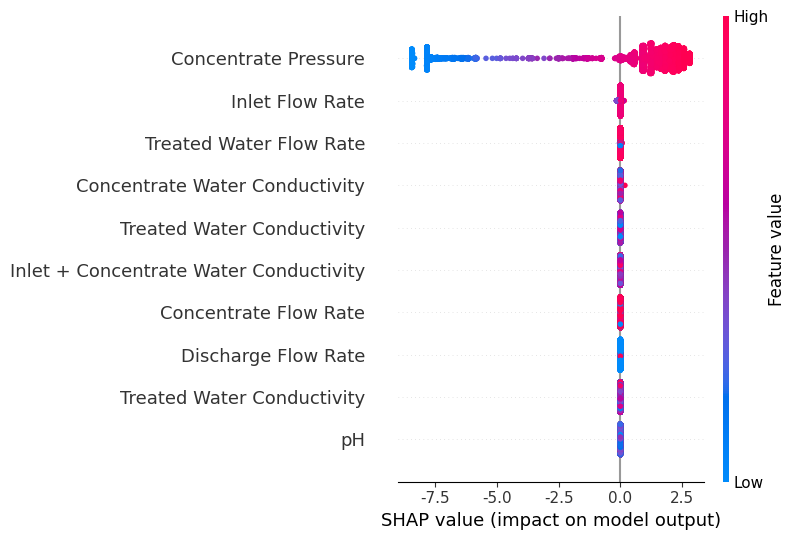

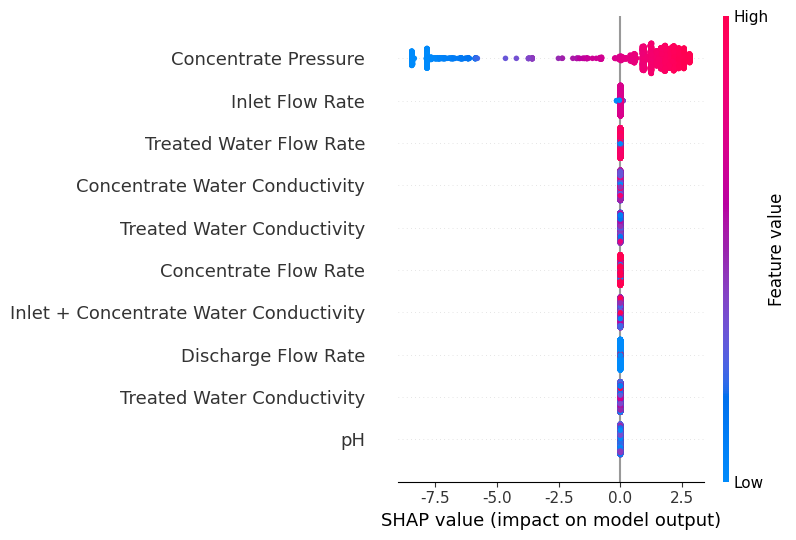

In [11]:
#트레이닝 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_train,X_train)

#테스트 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_test,X_test)